# Result comparaison for Superpixels Entropy

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import EntropyRateSuperpixel as ERS
import MyDataset as Data
import LambdaCoeff as LC

import SSGA

145 145 200


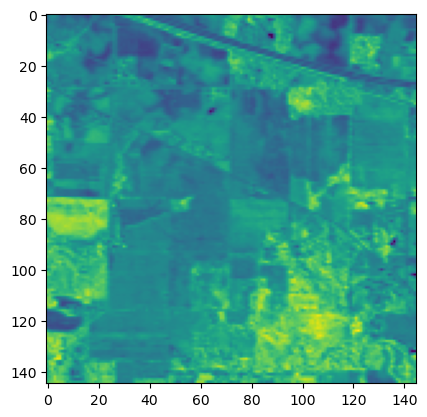

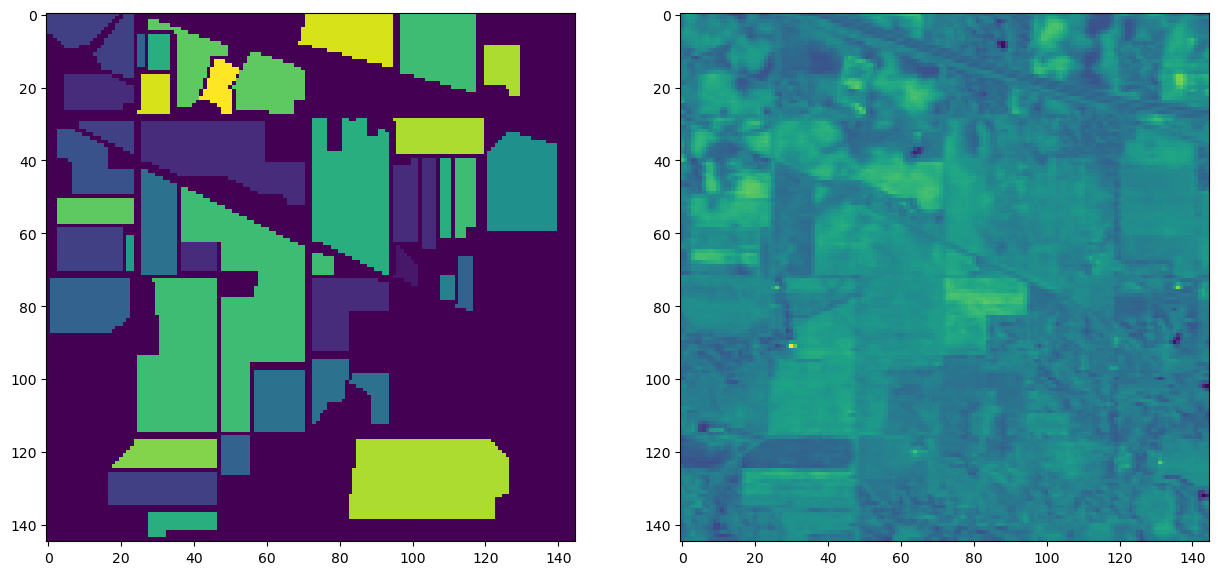

In [50]:
usedDataset = Data.IndianPines
#usedDataset = Data.PaviaUniversity
#usedDataset = Data.PaviaCenter


N,M,B = usedDataset["shape"]
trainData = usedDataset["data"]
print(N,M,B)

def crop_img(size, data):
    global N, M
    size = min(size, N, M)
    if size!=N and size!=M:
        xStart = np.random.randint(0, N-1-size)
        yStart = np.random.randint(0, M-1-size)
        trainData = data[xStart:xStart+size, yStart:yStart+size, :]
        trainData = Data.standardize_data(trainData)
        N,M,B = trainData.shape
    return trainData, xStart, yStart
#trainData,_,_ = crop_img(600, usedDataset["data"])

b = np.random.randint(0, B-1)
plt.imshow(trainData[:,:,b])
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].imshow(usedDataset["gt"])
axs[1].imshow(np.average(usedDataset["data"], axis=2))
plt.show()

## Compute SPs

In [51]:
RunDataFormat = False
useLambdasModel = True

import json
datasetFolder = "datasets/"
saved_file_name = {
    True: "FormatDataSuperpixels",
    False: "SimFunSuperpixels"
}

complete_save_file_name = datasetFolder + saved_file_name[RunDataFormat]
if useLambdasModel and not RunDataFormat:
    complete_save_file_name += "UsedLambdasModel"
complete_save_file_name +=  usedDataset["name"] +".json"
print(complete_save_file_name)

datasets/SimFunSuperpixelsUsedLambdasModelIndian Pines.json


In [5]:
def anovaFtest(clusters, dist=ERS.norm2_similarity):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    average = np.average([ts for cluster in clusters for ts in cluster], axis=0)

    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * dist(averages[k], average)
        for ts in clusters[k]:
            WGV += dist(ts, averages[k])
    
    if WGV==0:
        return np.inf
    return (n-K)/(K-1) * BGV/WGV


from sklearn.metrics import davies_bouldin_score
def DaviesBouldinIndex(clusters, dist=None):
    # Lower value means better clustering then we invert
    labels = [i for i,cluster in enumerate(clusters) for _ in range(len(cluster))]
    X = [ts for cluster in clusters for ts in cluster]
    return 1/davies_bouldin_score(X, labels)


def DunnIndex(clusters, dist=ERS.norm2_similarity):
    # High = well separated
    K = len(clusters)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])

    minAveragesDist = dist(averages[0], averages[1])
    maxDiameter = 0
    for i in range(K):
        for j in range(i+1, K):
            minAveragesDist = min(dist(averages[i], averages[j]), minAveragesDist)

        diameter = 0
        for j in range(len(clusters[i])):
            for k in range(j+1, len(clusters[i])):
                diameter = max(diameter, dist(clusters[i][j], clusters[i][k]))
        maxDiameter = max(diameter, maxDiameter)
    
    return minAveragesDist/maxDiameter


def XieBeniIndex(clusters, dist=ERS.norm2_similarity):
    # low value better then we invert
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])

    sum = 0
    minAveragesDist = dist(averages[0], averages[1])
    for k in range(K):
        for ts in clusters[k]:
            sum += dist(averages[k], ts)

        for j in range(k+1, K):
            minAveragesDist = min(dist(averages[k], averages[j]), minAveragesDist)
    
    return 1/(sum/minAveragesDist /n)



In [23]:
def normalize(vec):
    arr = np.array(vec)
    mini = arr.min()
    maxi = arr.max()
    if mini==maxi:
        return arr/len(arr)
    return (arr-mini)/(maxi-mini)


def stdFtestnorm1(clusters, dist=None):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    stds = [normalize(np.std(cluster, axis=0)) for cluster in clusters]

    TS = [ts for cluster in clusters for ts in cluster]
    average = np.average(TS, axis=0)
    std = normalize(np.std(TS, axis=0))


    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * (np.abs(averages[k]-average) * (1-stds[k]*std)**1).sum()
        for ts in clusters[k]:
            WGV += (np.abs(ts-averages[k]) * (1-stds[k]**2)**1).sum()
    
    if WGV==0:
        return np.inf
    return (n-K)/(K-1) * BGV/WGV


def stdFtestnorm1squared(clusters, dist=None):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    stds = [normalize(np.std(cluster, axis=0)) for cluster in clusters]

    TS = [ts for cluster in clusters for ts in cluster]
    average = np.average(TS, axis=0)
    std = normalize(np.std(TS, axis=0))


    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * (np.abs(averages[k]-average) * (1-stds[k]*std)**2).sum()
        for ts in clusters[k]:
            WGV += (np.abs(ts-averages[k]) * (1-stds[k]**2)**2).sum()
    
    if WGV==0:
        return np.inf
    return (n-K)/(K-1) * BGV/WGV


def stdExpFtestnorm1(clusters, dist=None):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    stds = [normalize(np.std(cluster, axis=0)) for cluster in clusters]

    TS = [ts for cluster in clusters for ts in cluster]
    average = np.average(TS, axis=0)
    std = normalize(np.std(TS, axis=0))


    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * (np.abs(averages[k]-average) * np.exp(-stds[k]*std)).sum()
        for ts in clusters[k]:
            WGV += (np.abs(ts-averages[k]) * np.exp(-stds[k]**2)).sum()
    
    if WGV==0:
        return np.inf
    return (n-K)/(K-1) * BGV/WGV


def stdExp2Ftestnorm1(clusters, dist=None):
    # High = well separated
    K = len(clusters)
    sizes = [len(cluster) for cluster in clusters]
    n = np.sum(sizes)
    averages = np.array([np.average(cluster, axis=0) for cluster in clusters])
    stds = [normalize(np.exp(np.std(cluster, axis=0))) for cluster in clusters]

    TS = [ts for cluster in clusters for ts in cluster]
    average = np.average(TS, axis=0)
    std = normalize(np.std(TS, axis=0))


    BGV = 0
    WGV = 0
    for k in range(K):
        BGV += sizes[k] * (np.abs(averages[k]-average) * (1-stds[k]*std)).sum()
        for ts in clusters[k]:
            WGV += (np.abs(ts-averages[k]) * (1-stds[k]**2)).sum()
    
    if WGV==0:
        return np.inf
    return (n-K)/(K-1) * BGV/WGV

In [7]:
def compute_Ks(N,M):
    # Want NM/K > 5 then K<NM/5
    Ksmax = int(N*M/5)
    Ks = [20, 50]
    k = 100
    while k<Ksmax:
        Ks.append(k)
        k *=2
    Ks.sort()
    return Ks


from sklearn.decomposition import PCA
def createInfo(data, Ks):
    SPsDic = ERS.find_superpixel(data, Ks, lambda_coef="auto", simFun="norm1")
    associations = np.zeros((len(Ks), N, M), dtype=int)
    for level, K in enumerate(Ks):
        SPs = SPsDic[K]
        for k,SP in enumerate(SPs):
            for x,y in SP:
                associations[level][x,y] = k

    def getSP(level, idSP):
        return SPsDic[Ks[level]][idSP]

    getParent = [[None for _ in range(len(SPsDic[K]))] for K in Ks]
    for level in range(1,len(Ks)):
        for k, SP in enumerate(SPsDic[Ks[level]]):
            getParent[level][k] = associations[level-1][SP[0]]


    getChilds = [[[] for _ in range(len(SPsDic[K]))] for K in Ks]
    for level in range(1, len(Ks)):
        SPs = SPsDic[Ks[level]]
        for k, SP in enumerate(SPs):
            botId = getParent[level][k]
            getChilds[level-1][botId] += [k]


    def divide_comp_var(level, idSP, data,
                        n_component=0,
                        varFun=anovaFtest,
                        dist=ERS.norm2_similarity):
        
        childsID = getChilds[level][idSP]
        if len(childsID)==0: return 0
        if len(childsID)==1: return 10e9

        childs = [getSP(level+1, id) for id in childsID]
        if n_component==0:
            clusters = [[data[coor] for coor in child] for child in childs]
            return varFun(clusters, dist=dist)
        
        clusters_id = [i for i,child in enumerate(childs) for _ in range(len(child))]
        TS = np.array([trainData[coor] for child in childs for coor in child])

        n_component = min(n_component, min(TS.shape))
        pca = PCA(n_components=n_component)
        coeffs = pca.fit_transform(TS)

        clusters = [[] for _ in range(len(childs))]
        for i in range(len(clusters_id)):
            clusters[clusters_id[i]].append(coeffs[i])
        clusters = [np.array(cluster) for cluster in clusters]
        return varFun(clusters, dist=dist)

    return SPsDic, getSP, getParent, getChilds, divide_comp_var


from classes import MinHeap
def multilevel_splitSP(data, K, n_component=0, usedVarFun=anovaFtest, dist=ERS.norm2_similarity, infos=None):
    N,M,_ = data.shape
    Ks = compute_Ks(N,M)
    if infos==None:
        infos = createInfo(data, Ks)
    SPsDic, getSP, getParent, getChilds, divide_comp_var = infos

    heap = MinHeap()
    for k in range(len(SPsDic[Ks[0]])):
        heap.insert((0, k), -divide_comp_var(0, k, data, n_component, varFun=usedVarFun, dist=dist))

    while 0<len(heap.array)<K:
        elt,w = heap.pop()
        level, idSP = elt
        childsID = getChilds[level][idSP]
        if childsID==[]:
            heap.insert((level, idSP), 0)
            break
        for id in childsID:
            heap.insert((level+1, id), -divide_comp_var(level+1, id, data, n_component, varFun=usedVarFun, dist=dist))

    return [getSP(pair.first[0], pair.first[1]) for pair in heap.array]

In [52]:
Ks = [50, 100, 200, 300, 400, 500, 600]
#Ks = [100, 300, 500, 700, 900, 1100, 1300, 1500]

ns_component = [0, 3, 10]

names = ["Norm1"] + ["ML F-norm1 "+str(n) for n in ns_component]

#names += ["ML DBI "+str(n) for n in ns_component]
#names += ["ML Dunn "+str(n) for n in ns_component]
#names += ["ML XBI "+str(n) for n in ns_component]

#names += ["ML F-norm2 "+str(n) for n in ns_component]
#names += ["ML F-std-norm1 "+str(n) for n in ns_component]
names += ["ML F-std"]
names += ["ML F-std²"]
names += ["ML F-std exp"]
names += ["ML F-std exp2"]

datas = names
trainData = Data.standardize_data(trainData)

In [53]:
SPsDic = {K:[] for K in Ks}

print("norm1")
SPs_dic_i = ERS.find_superpixel(trainData, Ks, lambda_coef="auto",simFun="norm1", updateLambda=True)
for K in Ks:
    SPsDic[K].append(SPs_dic_i[K])


norm1


In [54]:
Ks_or = compute_Ks(N,M)
print("info")
infos = createInfo(trainData, Ks_or)

info


In [55]:
for n in ns_component:
    print(n)
    for K in Ks:
        SPsDic[K].append(multilevel_splitSP(trainData, K, n_component=n, infos=infos,
                                            usedVarFun=anovaFtest, dist=ERS.norm1_similarity))

0
3
10


In [56]:
print(1)
for K in Ks:
    SPsDic[K].append(multilevel_splitSP(trainData, K, n_component=0, infos=infos,
                                        usedVarFun=stdFtestnorm1))

print(2)
for K in Ks:
    SPsDic[K].append(multilevel_splitSP(trainData, K, n_component=0, infos=infos,
                                            usedVarFun=stdFtestnorm1squared))

print(3)
for K in Ks:
    SPsDic[K].append(multilevel_splitSP(trainData, K, n_component=0, infos=infos,
                                            usedVarFun=stdExpFtestnorm1))

print(4)
for K in Ks:
    SPsDic[K].append(multilevel_splitSP(trainData, K, n_component=0, infos=infos,
                                            usedVarFun=stdExp2Ftestnorm1))

1
2
3
4


In [ ]:
if RunDataFormat:
    data1 = usedDataset["data"].copy()
    data2 = Data.normalized_data(usedDataset["data"].copy())
    data3 = Data.standardize_data( usedDataset["data"].copy() )
    datas = [data1, data2, data3]
    names = ["Basic", "Normalized", "Standardized"]
else:
    datas = ["average", "norm2", "norm1", "perason"]
    names = ["Average", "Norm2", "Norm1", "Perason"]
    trainData = Data.standardize_data(trainData)
    getLambdas = [LC.getLambdaAverage, LC.getLambdaNorm2, LC.getLambdaNorm1]


FoundLambdaCoeffKey = "DataFormat" if RunDataFormat else "SimilarityFunction"
LambdaCoeffs = Data.FoundLambdaCoeff[FoundLambdaCoeffKey]


if usedDataset["name"] in [Data.IndianPines["name"], Data.PaviaUniversity["name"]]:
    Ks = list(LambdaCoeffs[usedDataset["name"]].keys())
else:
    Ks = [100, 200, 300, 400, 500, 600]

Ks = [100, 300, 500, 700, 900, 1100, 1300] 
    
if len(Ks)==1:
    complete_save_file_name = complete_save_file_name[:len(complete_save_file_name)-5] + str(Ks[0]) + "SP.json"
    print(complete_save_file_name)
Ks.sort(key=lambda x:x)

print(trainData.shape)
print(Ks)

(145, 145, 200)
[100, 300, 500, 700, 900, 1100, 1300]


In [ ]:
def compute_SPs(Ks, save_data=False, find_lambda=True):
    SPsDic = {K:[] for K in Ks}

    if (not RunDataFormat) and useLambdasModel:
        for i,funName in enumerate(datas):
            print("i =", i, "(" + funName + ")")
            SPs_dic_i = ERS.find_superpixel(trainData, Ks,
                                           lambda_coef="auto",
                                           simFun=funName,
                                           updateLambda=True)
            for K in Ks:
                SPsDic[K].append(SPs_dic_i[K])
    
    else:
        SPsDic = {}
        for K in Ks:
            print("K:", K)
            Ps = LC.computePs(K, N, M)

            current_list = []
            for i,data in enumerate(datas):
                print(i, end=" ")
                if RunDataFormat:

                    fun = ERS.create_CSF("average", data)
                    if find_lambda:
                        SPs, coeff = LC.dichotomies_search(data, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        SPs = ERS.find_superpixel(data, K,
                                                lambda_coef=LambdaCoeffs[usedDataset["name"]][K][i],
                                                simFun="average")
                else:
                    if find_lambda:
                        fun = ERS.create_CSF(data, trainData)
                        SPs, coeff = LC.dichotomies_search(trainData, K, 1, 400, fun, Ps)
                        print("Choosen Coef:", coeff)
                    else:
                        lc = LambdaCoeffs[usedDataset["name"]][K][i]
                        SPs = ERS.find_superpixel(trainData, K,
                                                    lambda_coef=lc,
                                                    simFun=data)
                current_list.append(SPs)
            print()
            SPsDic[K] = current_list


    if save_data:
        json_object = json.dumps(SPsDic)
        with open(complete_save_file_name, "w") as f :
            f.write(json_object)
            f.close()
    return SPsDic


SPsDic = compute_SPs(Ks, save_data=True, find_lambda=False)

i = 0 (average)
i = 1 (norm2)
i = 2 (norm1)
i = 3 (perason)


In [63]:
with open(complete_save_file_name, "r") as f:
    tempDic = json.load(f)
    f.close()
SPsDic = {}
for key, dataListe in tempDic.items():
    SPsDic[int(key)] = [[[tuple(coor) for coor in SP] for SP in SPsListe] for SPsListe in dataListe]

Ks = list(SPsDic.keys())
Ks.sort()

### Superpixels Classifier

In [57]:
ClassifierDic:dict[int, list[ERS.SuperpixelClassifier]] = {}
for b in [True, False]:
    ClassifierDic[b] = {}
    for K in Ks:
        ClassifierDic[b][K] = [
            ERS.SuperpixelClassifier(SPs, usedDataset["labels"], usedDataset["gt"], counting0=b)
                    for SPs in SPsDic[K]
            ]

### Visual result

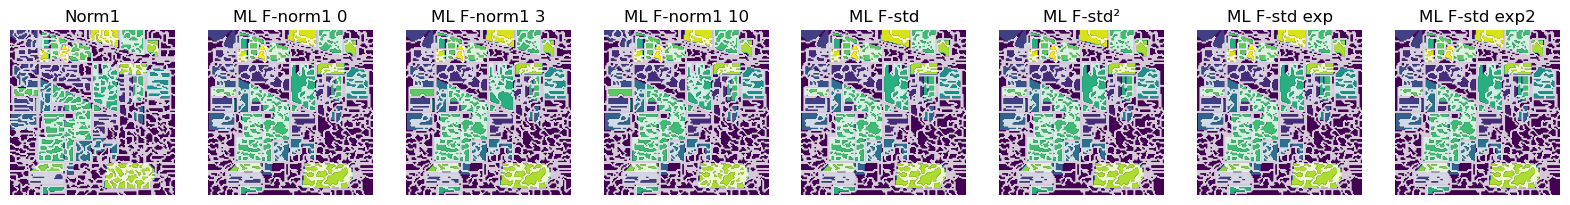

True


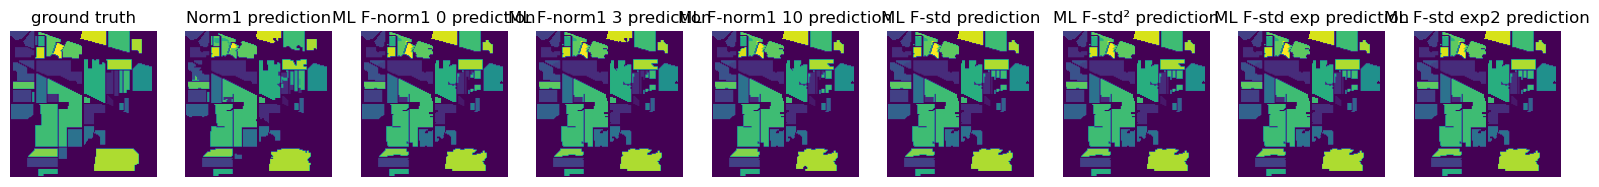

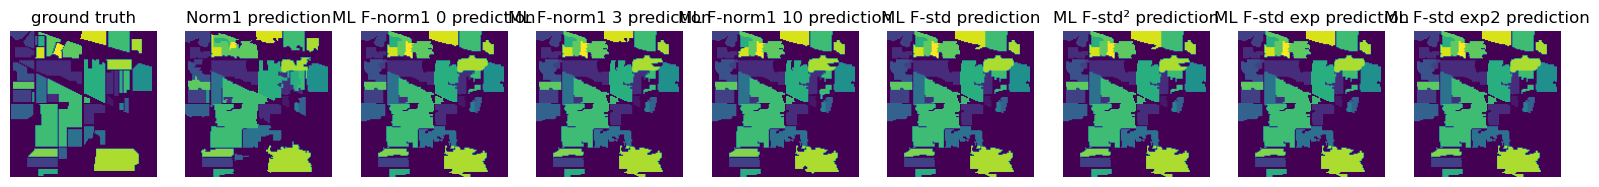

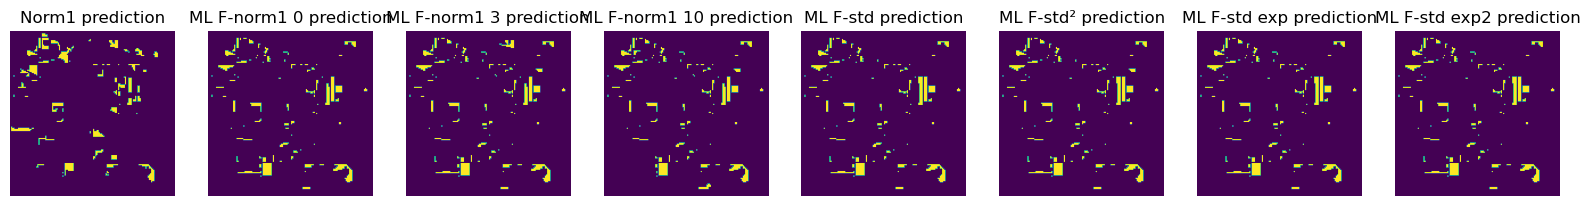

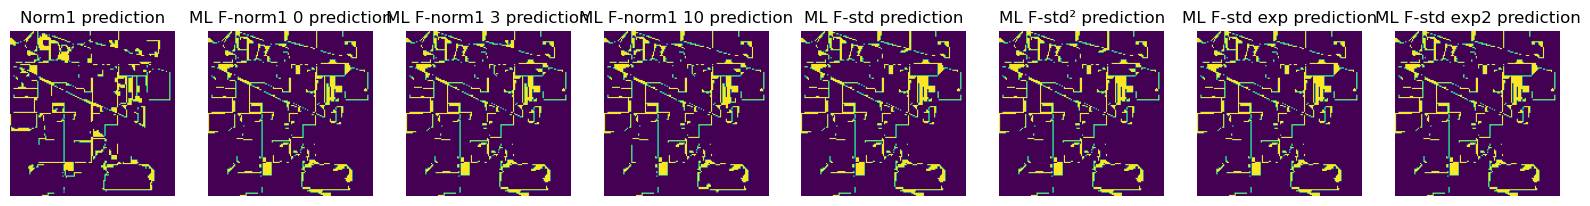

False


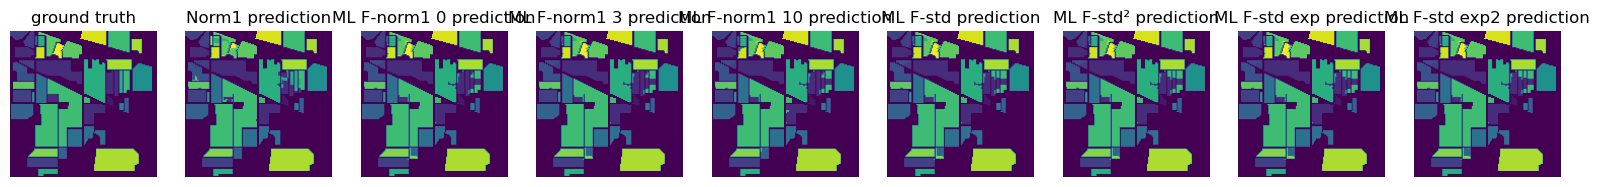

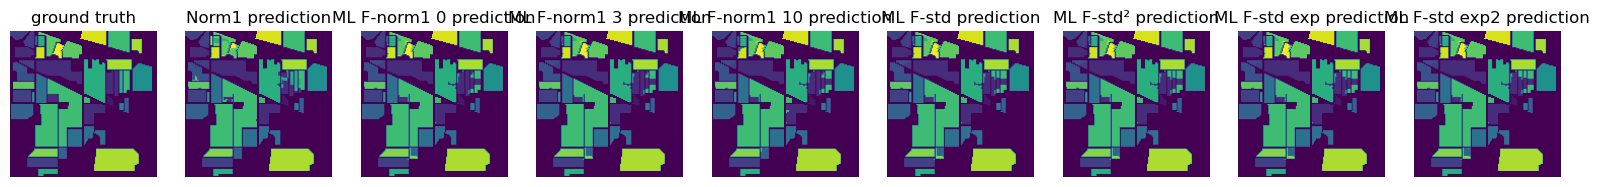

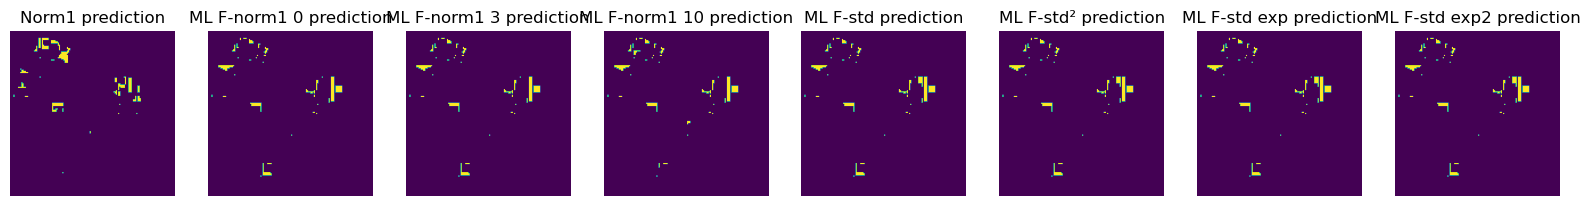

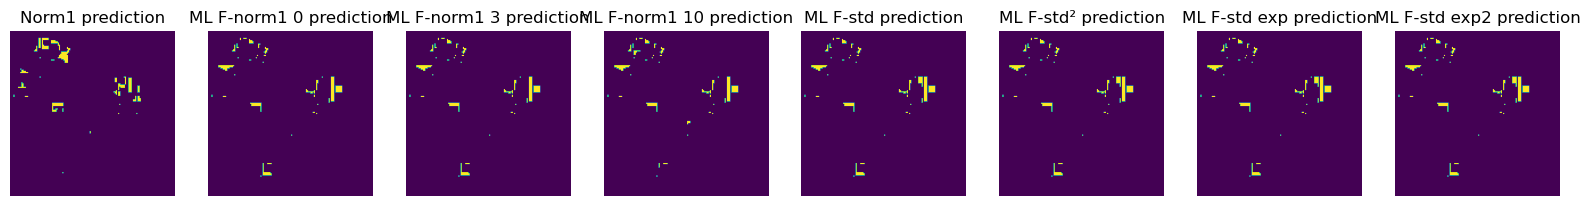

In [58]:
K = 400

fig, axs = plt.subplots(1, len(SPsDic[K]))
fig.set_size_inches(20,30)
for i,SP in enumerate(SPsDic[K]):
    axs[i].imshow(usedDataset["gt"])
    axs[i].imshow(ERS.create_overlay_borders(usedDataset["gt"], SP, color=[255,255,255,200]))
    axs[i].title.set_text(names[i])
    axs[i].axis("off")
plt.show()



for b in [True, False]:
    print(b)
    classifiers = ClassifierDic[b][K]

    imgs = [usedDataset["gt"]] + [C.guess_map for C in classifiers]
    titles = ["ground truth"] + [name+" prediction" for name in names]


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]==0:
                    new_img[x,y] = 0
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers)+1)
    fig.set_size_inches(20,30)
    for i in range(len(imgs)):
        new_img = imgs[i].copy()
        new_img[0,0] = max(usedDataset["labels"])
        axs[i].imshow(new_img)
        axs[i].title.set_text(titles[i])
        axs[i].axis("off")
    plt.show()


    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=0 and usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()

    fig, axs = plt.subplots(1, len(classifiers))
    fig.set_size_inches(20,30)
    for i in range(1, len(imgs)):
        new_img = np.zeros((N,M))
        for x in range(N):
            for y in range(M):
                if usedDataset["gt"][x,y]!=imgs[i][x,y]:
                    new_img[x,y] = 1

        axs[i-1].imshow(new_img)
        axs[i-1].title.set_text(titles[i])
        axs[i-1].axis("off")
    plt.show()


### Classification result

In [59]:
size = len(ClassifierDic[True][Ks[0]])
overallAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageAccuracys = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedJaccard = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
singleClassCounts = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}
averageWeightedProportions = {b:{K:[0 for _ in range(size)] for K in Ks} for b in [True,False]}

labelsAccuracy = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}
labelsJaccard = {b:{
        l:{K:[0 for _ in range(size)] for K in Ks} for l in usedDataset["labels"]
    } for b in [True, False]}

for b in [True, False]:
    print(b)
    for K in Ks:
        for i,C in enumerate(ClassifierDic[b][K]):
            overallAccuracys[b][K][i] = C.overallAccuracy(usedDataset["gt"])
            averageAccuracys[b][K][i] = C.averageAccuracy(usedDataset["gt"])
            averageWeightedJaccard[b][K][i] = C.averageWeightedJaccard(usedDataset["gt"], usedDataset["class"])
            singleClassCounts[b][K][i] = C.singleClassProportion()
            averageWeightedProportions[b][K][i] = C.averageWeightedProportion()
        
            for label in usedDataset["labels"]:
                if label in C.labels:
                    labelsAccuracy[b][label][K][i] = C.labelAccuracy(usedDataset["class"], label)
                    labelsJaccard[b][label][K][i] = C.jaccard(usedDataset["gt"], usedDataset["class"], label)
        

True
False


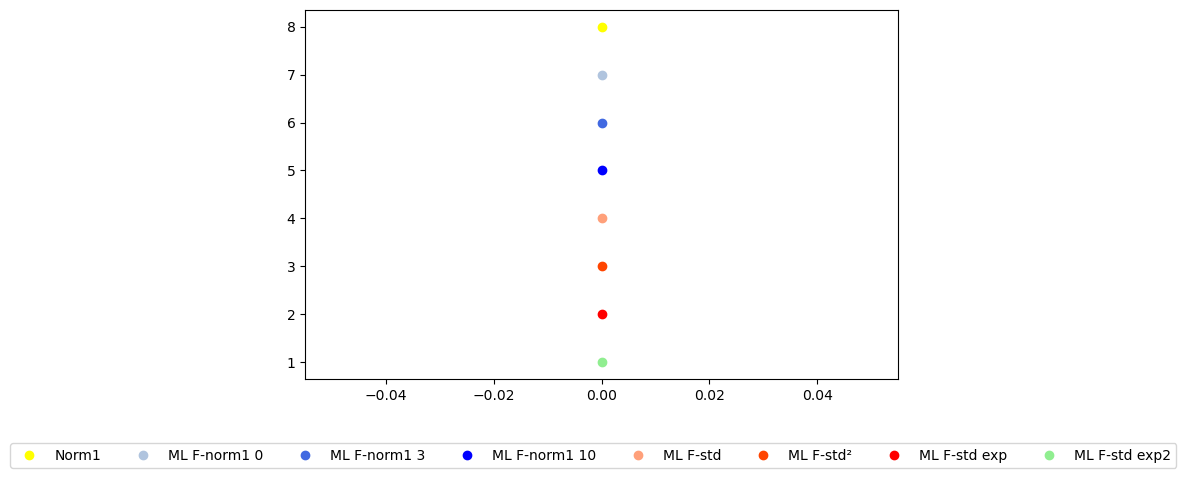

True


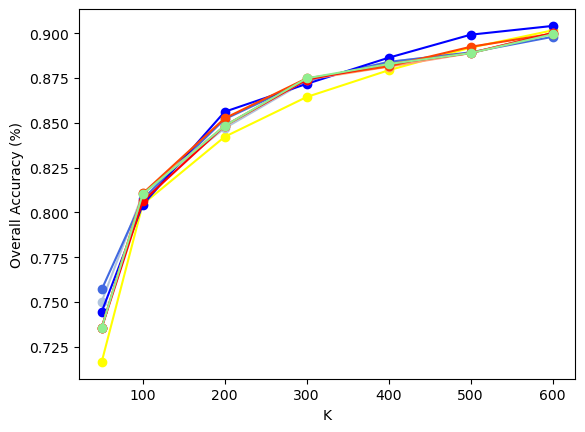

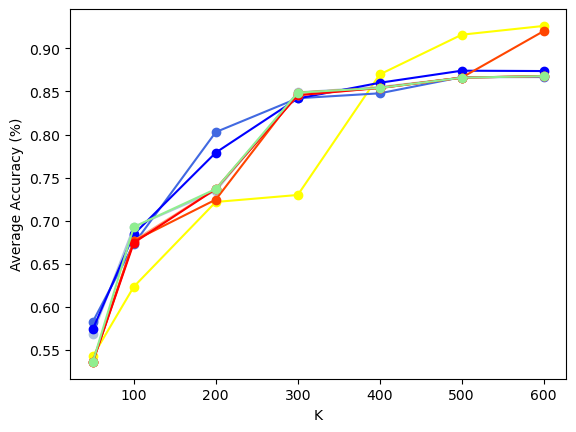

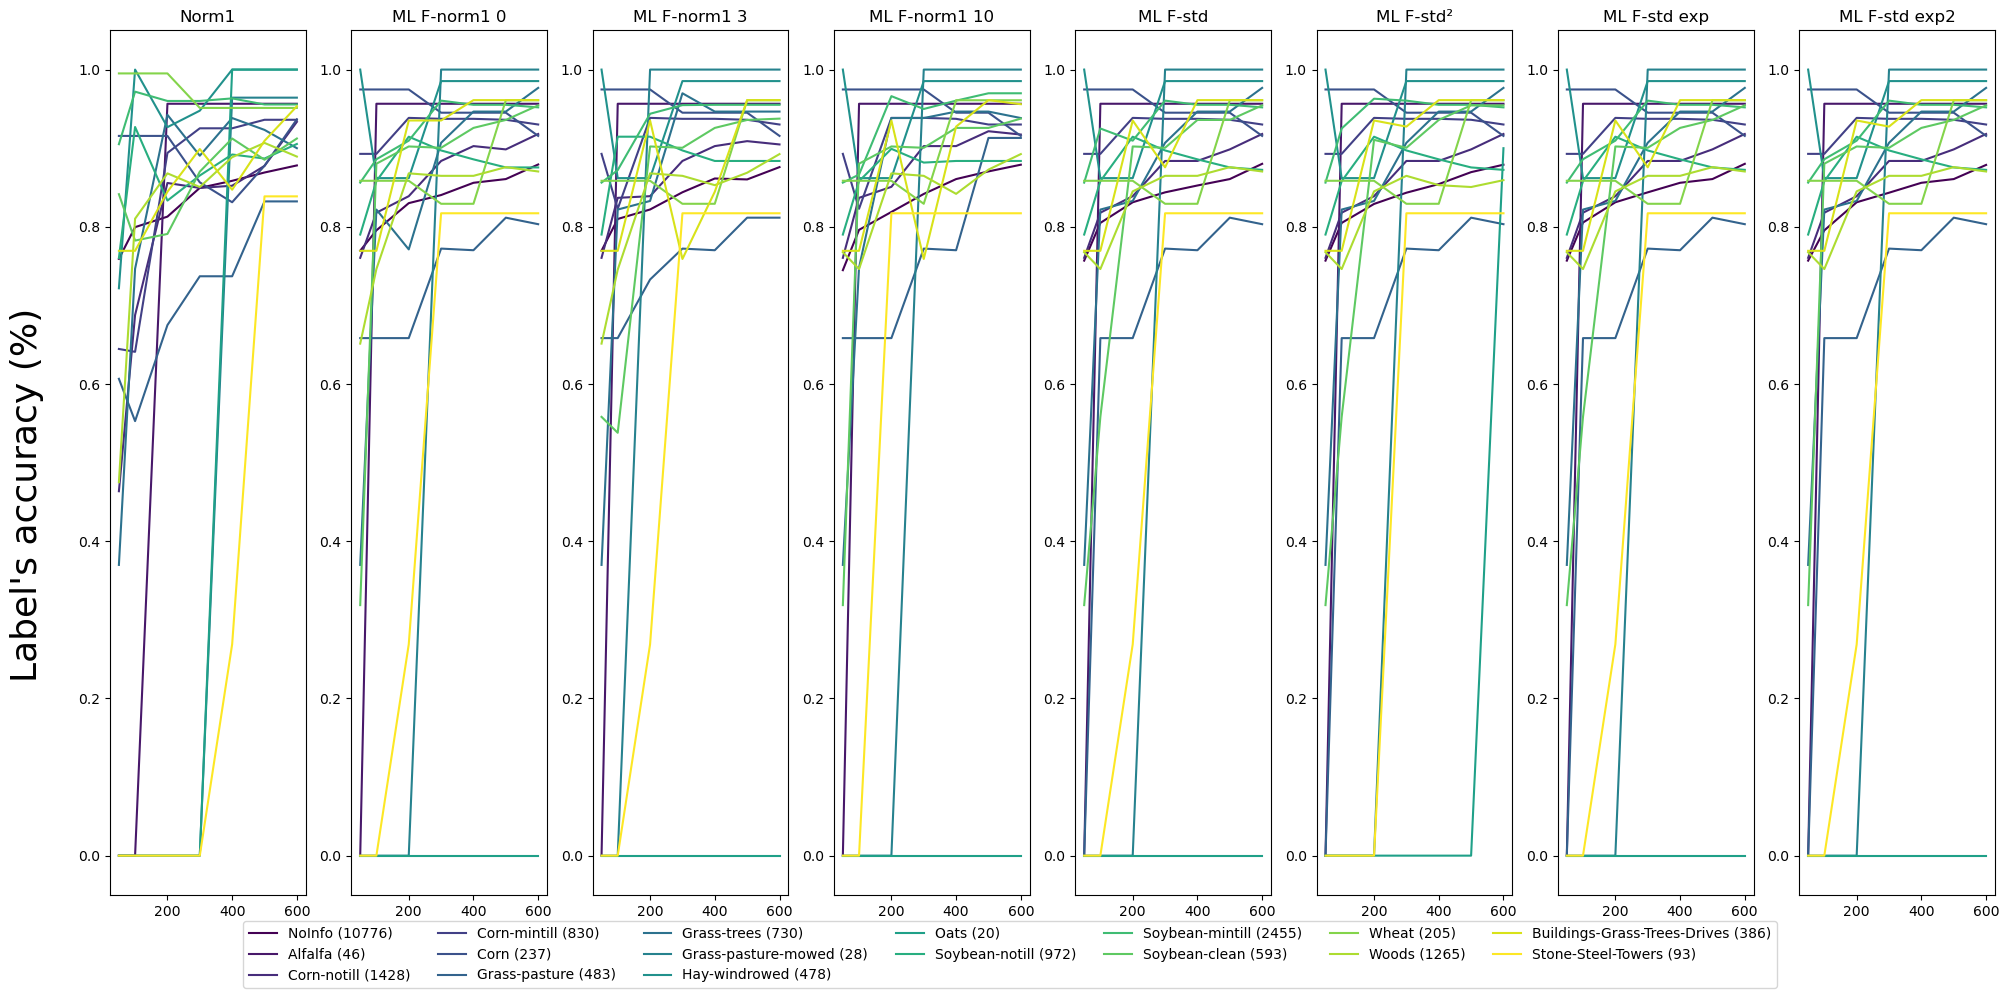

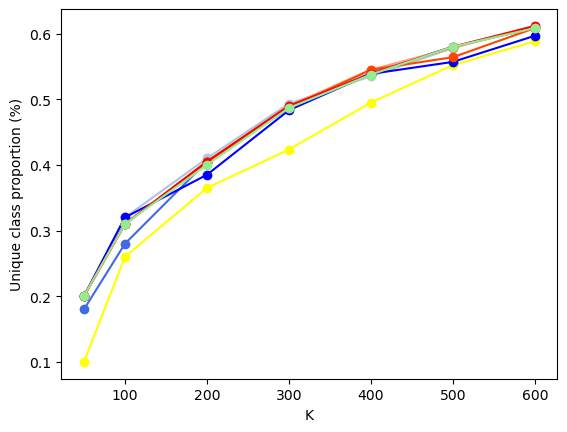

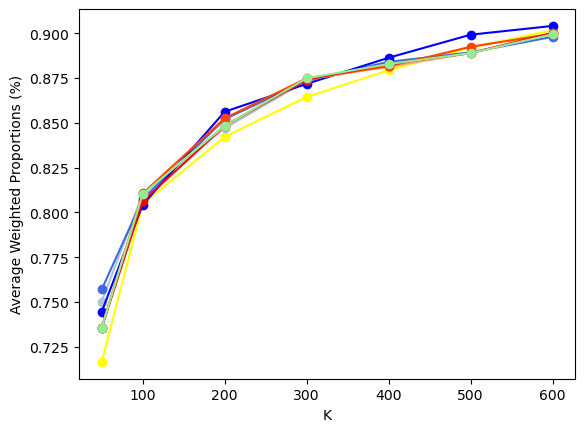

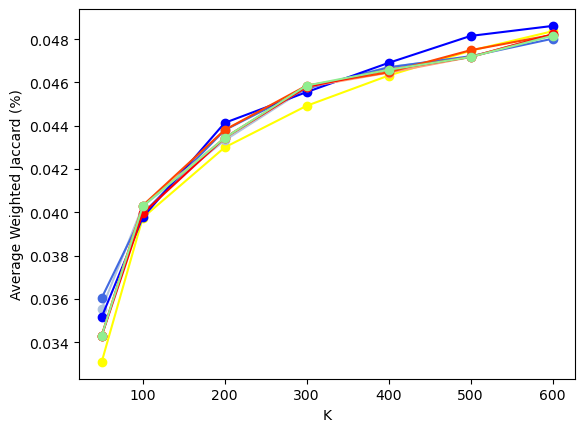

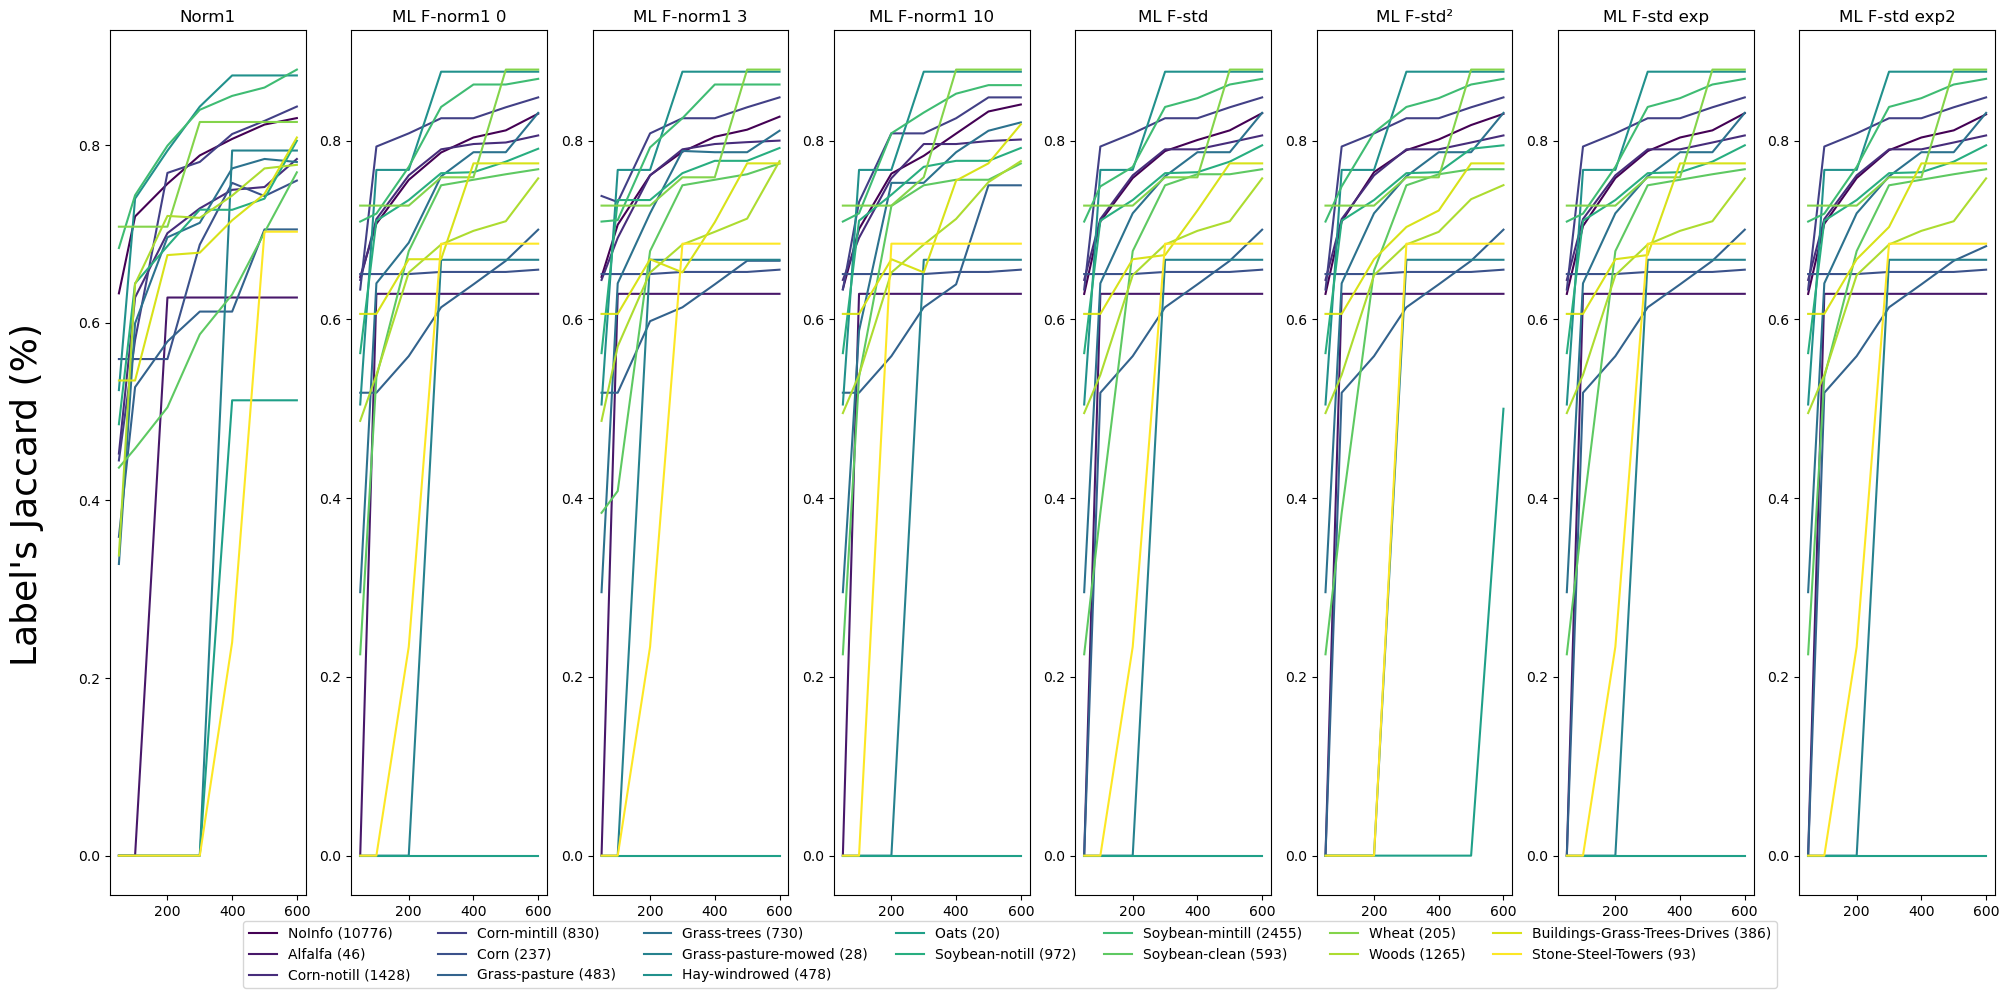

False


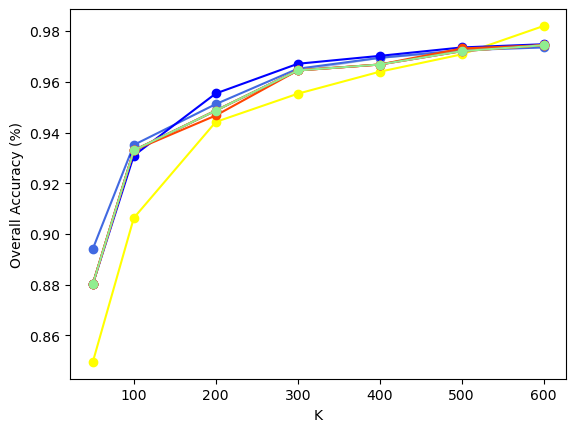

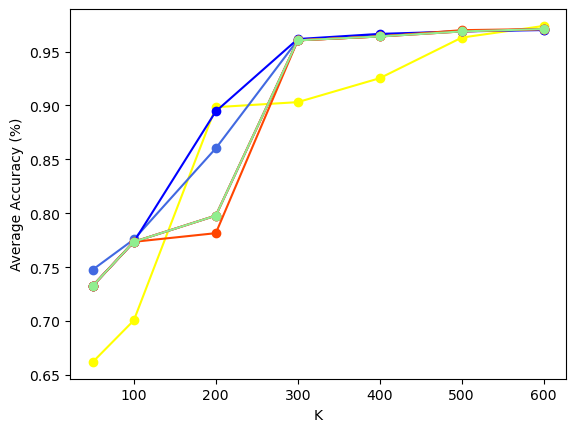

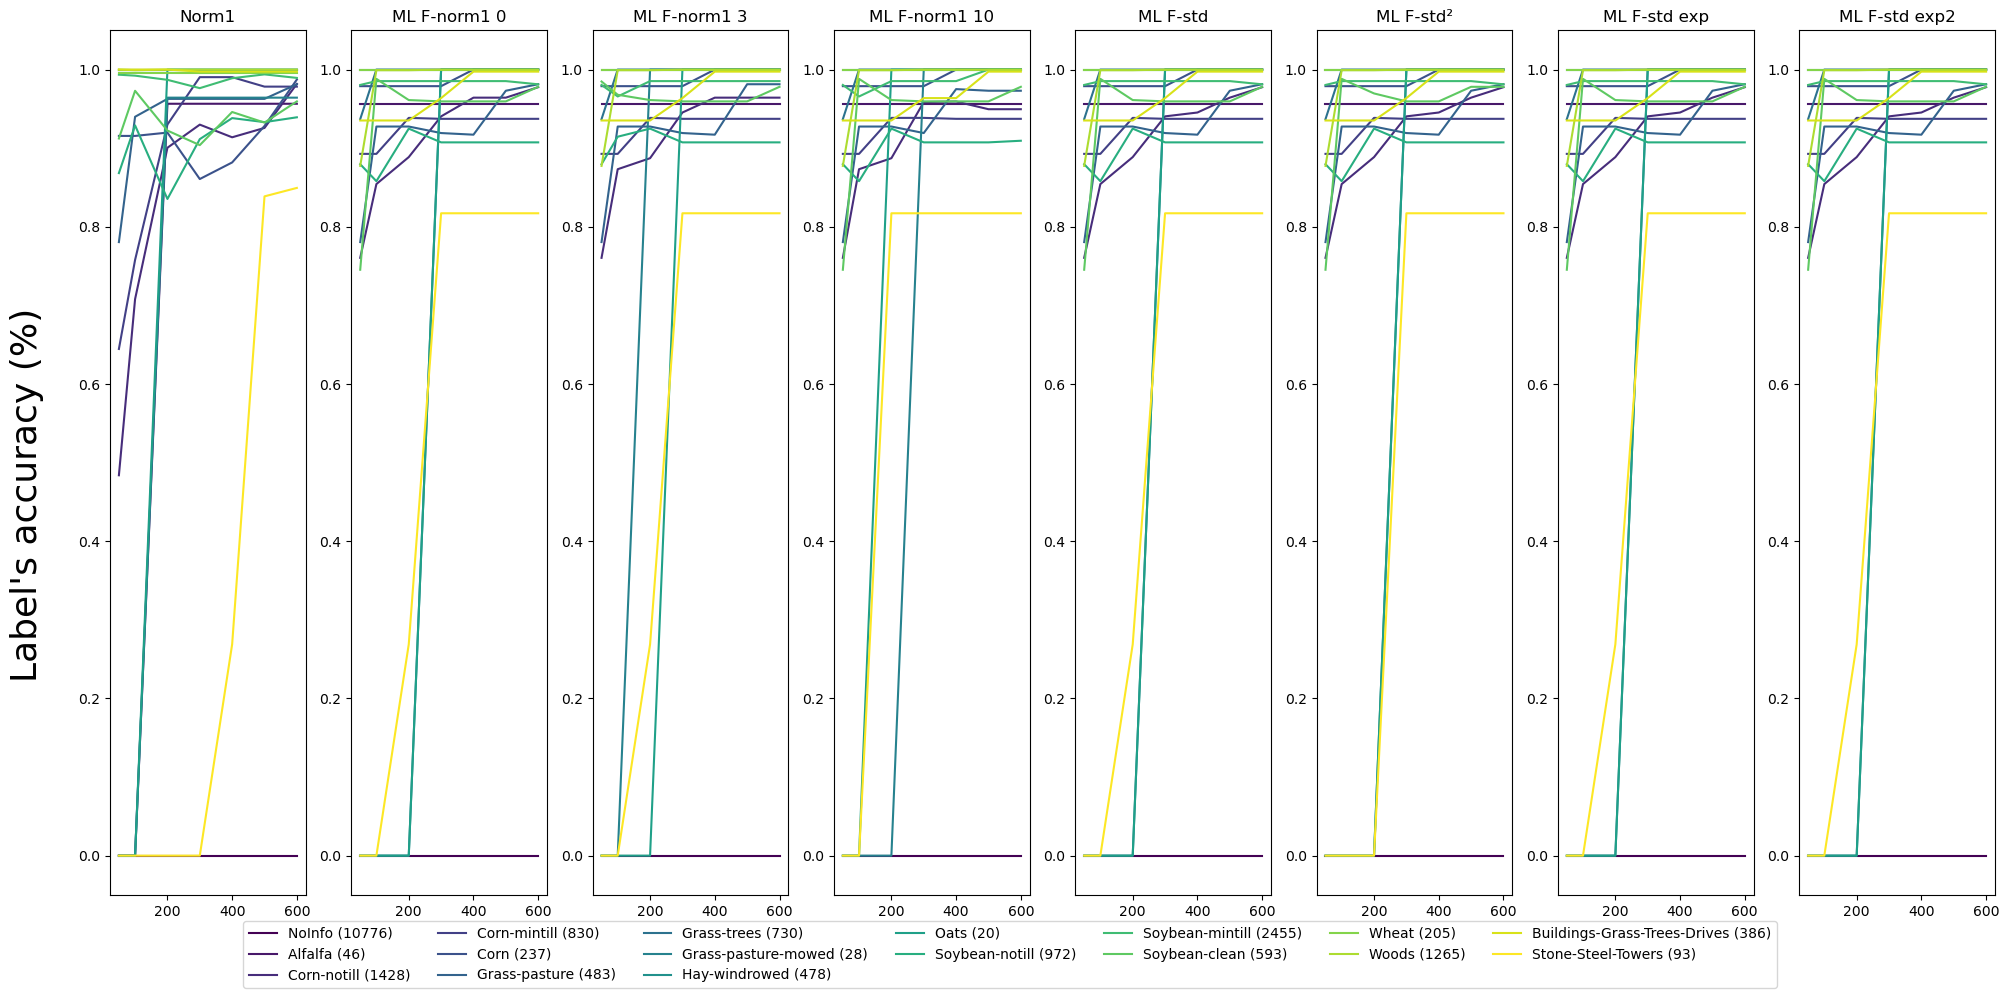

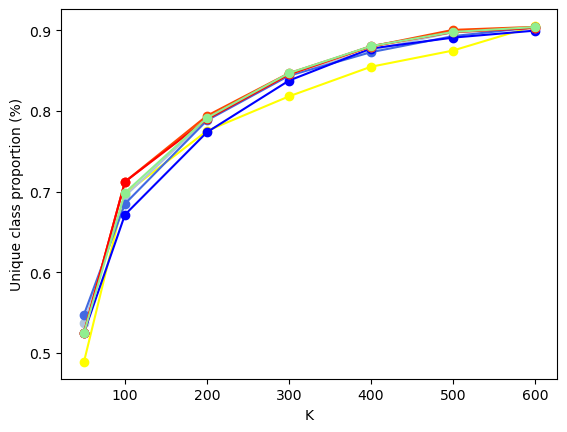

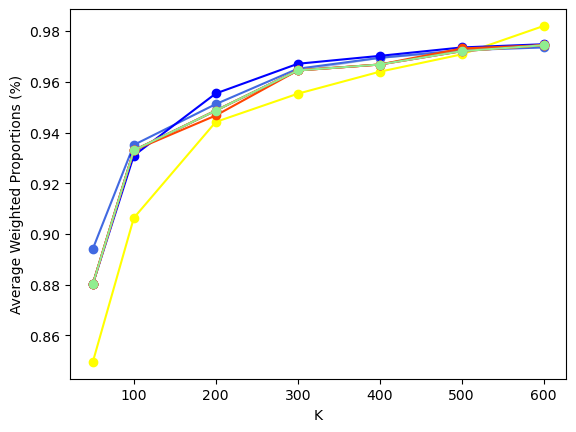

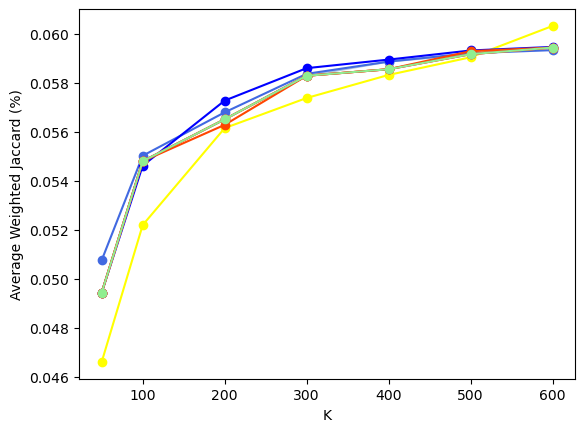

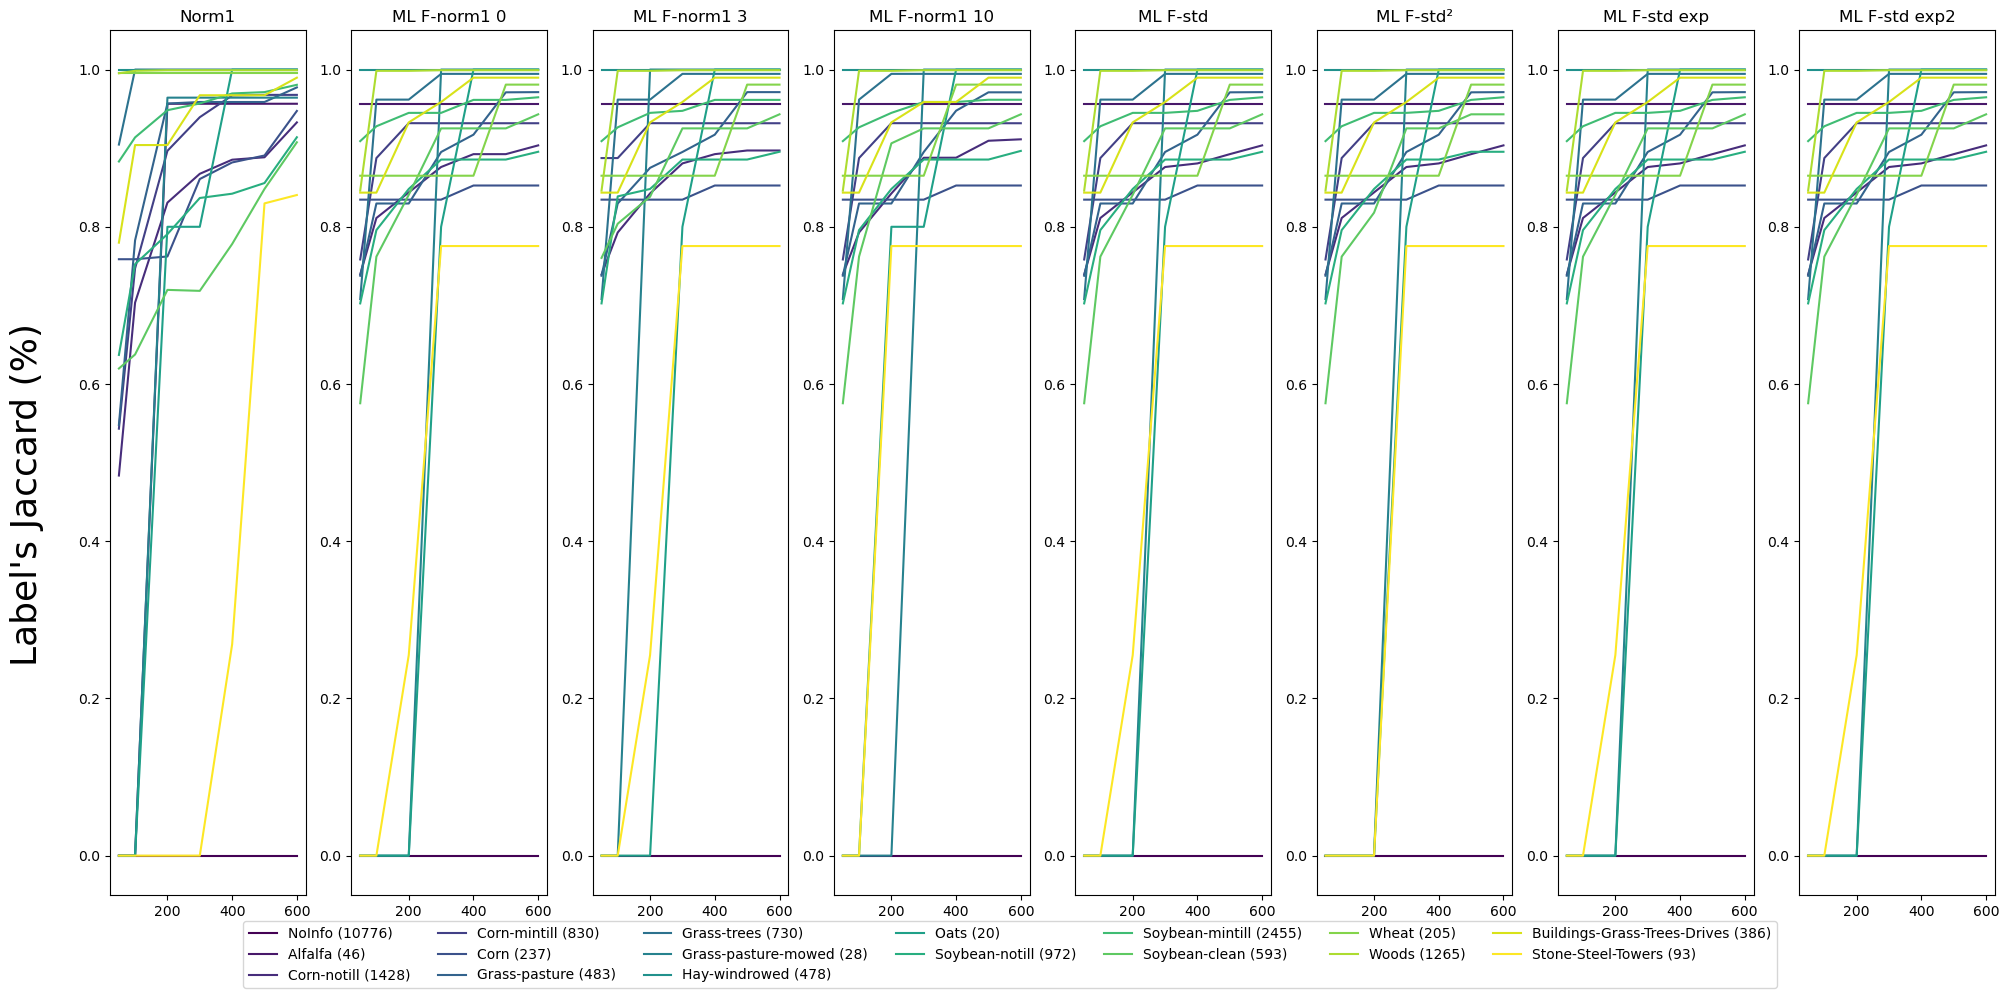

In [60]:
colors = ["yellow",
            "lightsteelblue", "royalblue", "blue",
            "lightsalmon", "orangered", "red",
            "lightgreen", "mediumseagreen", "darkgreen"]
#colors = ["orange", "mediumseagreen", "royalblue", "violet", "red"]
def plot_info(info, ylabel="", plotbar=False):
    if plotbar:
        for k,K in enumerate(Ks):
            if K!=50:
                for d in range(size):
                    plt.bar(K+ d*20 -20, info[K][d], color=colors[d], width=20)
    else:
        length = len(info[Ks[0]])
        for i in range(length):
            plt.plot(Ks, [info[K][i] for K in Ks], "-o", color=colors[i])
            
    plt.xlabel("K")
    plt.ylabel(ylabel)
    plt.show()


def plot_label_info(info, ylabel=""):
    fig, axs = plt.subplots(1, len(datas), figsize=(20,10), sharex=True)
    for i in range(len(datas)):
        for label in usedDataset["labels"]:
            if label in info.keys():
                axs[i].plot(Ks, [info[label][K][i] for K in Ks], "-",
                            color=labels_color[label],
                            label=usedDataset["class"][label][0]+" ("+str(len(usedDataset["class"][label][1]))+")")
        axs[i].title.set_text(names[i])
    
    fig.text(0.0, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.0))

    plt.tight_layout()
    plt.subplots_adjust(left=0.05)  
    plt.subplots_adjust(bottom=0.10)
    plt.show()



fig, ax = plt.subplots()
for i in range(len(datas)):
    plt.plot(0,len(datas)-i,"o", color=colors[i], label=names[i])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(datas), bbox_to_anchor=(0.5, -0.0))

plt.tight_layout()
plt.subplots_adjust(left=0.05)  
plt.subplots_adjust(bottom=0.20)
plt.show()


plotBar = False
motifs = ["-o", "--s", ":^"]
cmap = mpl.colormaps["viridis"]
labels_color = cmap(np.linspace(0, 1, max(usedDataset["labels"])+1))
for b in [True, False]:
    print(b)
    plot_info(overallAccuracys[b], "Overall Accuracy (%)", plotbar=plotBar)
    plot_info(averageAccuracys[b], "Average Accuracy (%)", plotbar=plotBar)
    plot_label_info(labelsAccuracy[b], "Label's accuracy (%)")
    plot_info(singleClassCounts[b], "Unique class proportion (%)", plotbar=plotBar)
    plot_info(averageWeightedProportions[b], "Average Weighted Proportions (%)", plotbar=plotBar)
    plot_info(averageWeightedJaccard[b], "Average Weighted Jaccard (%)", plotbar=plotBar)
    plot_label_info(labelsJaccard[b], "Label's Jaccard (%)")

### GA result

In [61]:
import sklearn.utils
from sklearn.preprocessing import StandardScaler

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1

            np.random.shuffle(indices)

            weights[key] = nb_info/ len(liste)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    


from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


def SVM_accuracy(X_train,y_train, X_test,y_test):
    pipeline = Pipeline([
        ('scalar', StandardScaler()),
        ('svc', svm.SVC(kernel='rbf'))
    ])

    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
        'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001]
    }

    clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    return len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]]) /len(y_pred)


In [62]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

pourcents = {
    Data.IndianPines["name"]: 0.05,
    Data.IndianPinesMerged["name"]: 0.05,
    Data.PaviaUniversity["name"]: 0.02,
    Data.PaviaCenter["name"]: 0.01
}

best_fitness = {K:[0 for _ in range(len(datas))] for K in Ks}
best_accuracy = {K:[0 for _ in range(len(datas))] for K in Ks}

trainingData = usedDataset["data"]

S_list = {K:[SSGA.compute_Sbsp_Stsp_list(trainData, SPsDic[K][i]) for i in range(len(datas))] for K in Ks}
A = 10
for K in Ks:
    print("K:", K)
    for i in range(len(datas)):
        for a in range(A):
            print(a, end=" ")
            pop, fitness = SSGA.SSGA(trainingData, 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2,
                                SP=SPsDic[K][i], S_list=S_list[K][i])
            best_fitness[K][i] += fitness[0]

            bands = pop[0]
            X_train,y_train, X_test,y_test, weights = split_data(usedDataset, pourcents[usedDataset["name"]], bands)
            best_accuracy[K][i] += SVM_accuracy(X_train,y_train, X_test,y_test)

        best_fitness[K][i] /= A
        best_accuracy[K][i] /= A
        print()

KeyboardInterrupt: 

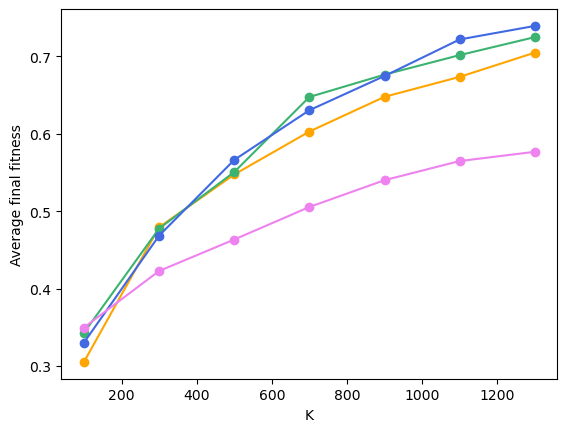

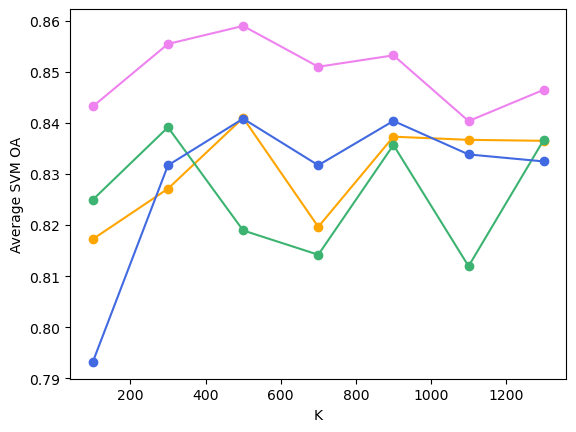

K = 100
[0.8172490280726024, 0.8249600496100365, 0.7932358623321487, 0.8431917380208457]
K = 300
[0.827109022825387, 0.8391227609893388, 0.8316812555155388, 0.8554177498986334]
K = 500
[0.8409592863787058, 0.8189472177832899, 0.8408066401125766, 0.8589429246070551]
K = 700
[0.8196532067641377, 0.8141961027500179, 0.8316931810050804, 0.85095761681017]
K = 900
[0.8372838505020631, 0.83566198392444, 0.8403630119016385, 0.8531876833544016]
K = 1100
[0.8366661101438213, 0.8119564958141531, 0.8338135330455316, 0.8403367758246476]
K = 1300
[0.8364753023111599, 0.8366589548500964, 0.8324421017482768, 0.8464545519593578]


In [ ]:
plot_info(best_fitness, "Average final fitness")
plot_info(best_accuracy, "Average SVM OA")
for K in Ks:
    print("K =", K)
    print(best_accuracy[K])